# **Recitation 3**

This lab concerns maximizing profit in a production model. To begin, skim through pages 1-5 of the following chapter: https://ampl.com/BOOK/CHAPTERS/04-tut1.pdf

In [1]:
# Click the "Play" button on the left to import packages.
%pip install -i https://pypi.gurobi.com gurobipy;
import gurobipy
import cvxpy as cp
import numpy as np
import pandas as pd

# Below function will simplify the conversion of numpy arrays into dataframes
def to_df(a): # turns array into pandas dataframe
  df = pd.DataFrame(data    = a[1:,1:] , # values
                    index   = a[1:,0]  , # 1st column as rows
                    columns = a[0,1:]  ) # 1st row as the column names
  df = df.astype('float') # Turn dataframe entries into floats
  return df

Looking in indexes: https://pypi.gurobi.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 25.6 MB/s eta 0:00:00


# **Exercise**
Like the model in the chapter, we must choose how much of each of three products - bands, coils, and plates - a plant should manufacture. In the code below, each product has a *rate*, which is the number of units produced in an hour, a *profit* per unit, a *commit* minimum amount that must be produced, and a *market* maximum amount. We have, in total,40 hours of manufacturing time that we can divide up between these three products, and we wish to maximize the total profits. We will consider constraint sensitivity in this problem. In Lab 2, we saw code to pull out sensitivity information.

**(a)**
**Reference Model 1**

In [ ]:
avail = 40

prod_info = to_df(np.array([  [ ''    , 'rate', 'profit', 'commit', 'market' ],
                              ['bands', 200   ,  25     ,  1000   , 6000],
                              ['coils', 140   ,  30     ,  500    , 4000],
                              ['plate', 160   ,  29     ,  750    , 3500]]))

In [ ]:
def steel(prod_info, avail):
  # Products
  prod = list(prod_info.index) # Row names of prod_info (pulls out products)

  # Make sure all fields are non-negative and numeric
  assert np.all(prod_info.to_numpy(dtype=float) >= 0)
  assert avail >=0

  # Make variables and constraints for amount of each product to make
  make = {}
  constraints = []
  for p in prod:
    v = cp.Variable(name=p)
    make[p] = v
    constraints += [v >= prod_info.loc[p, 'commit']] # Minimum commit
    constraints += [v <= prod_info.loc[p, 'market']] # Maximum ammount

  # Objective: total profits from all products
  total_profit = sum(prod_info.loc[p, 'profit'] * make[p] for p in prod)

  # Total of hours used by all products may not exceed hours available
  constraints += [sum((1/prod_info.loc[p,'rate'] * make[p] for p in prod)) <= avail]

  # Create and solve problem
  problem = cp.Problem(cp.Maximize(total_profit), constraints)
  problem.solve(solver=cp.GUROBI)

  # print output
  print('objective %s' % problem.value)
  for variable in problem.variables():
    print("%s = %s" % (variable.name(), variable.value))

  ## ADD PART (a) CODE BELOW: ##

  ## END OF PART (a) ##

  return problem.value # Outputs profit

We now call the model with the data:

In [ ]:
steel(prod_info, avail);

objective 194828.57142857145
bands = 6000.0
coils = 500.0
plate = 1028.571428571429


**Question for (a):**
Modify the Reference Model 1 code-block after the line `## ADD PART (a) CODE BELOW: ##`), in order to include the sensitivity information.  Rerun the notebook and interpret the sensitivity information.

**Give sensitivity interpretation for (a) below:**

**(b)**
**Reference Model 2**

Now suppose that there are two different **stages** to the manufacturing process: "roll" and "reheat". We may not exceed 35 hours in the reheat stage, and we may not exceed 40 hours in the roll stage. Moreover, the rates are now *different* for each stage, as described in a separate dataframe `rate`. Reference code for solving this new problem is below.

In [ ]:
availS = {'reheat': 35,
         'roll'  : 40}

prod_infoS = to_df(np.array([ [ ''    , 'profit', 'commit', 'market' ],
                              ['bands',  25     ,  1000   , 6000],
                              ['coils',  30     ,  500    , 4000],
                              ['plate',  29     ,  750    , 3500]]))

rate = to_df(np.array([ [ ''    , 'reheat', 'roll'],
                        ['bands', 200     ,  200  ],
                        ['coils', 200     ,  140  ],
                        ['plate', 200     ,  160  ]]))

In [ ]:
def steel2(prod_infoS, rate, availS):

  # Products and stages
  prod  = list(prod_infoS.index) # Row names of prod_info (pulls out products)
  stage = list(rate.columns) # Column names of rate (pulls out stages)

  # Make sure rate and availability match
  assert set(rate.columns) == set(availS.keys())

  # Make sure all availability, production, and rates are numeric and nonnegative
  assert np.all(np.array(list(availS.values())) >= 0)
  assert np.all(prod_infoS.to_numpy(dtype=float) >= 0)
  assert np.all(rate.to_numpy(dtype=float) >= 0)

  # Make variables and constraints for amount of each product to make
  make = {}
  constraints = []
  for p in prod:
    v = cp.Variable(name=p)
    make[p] = v
    constraints += [v >= prod_infoS.loc[p, 'commit']] # Minimum commit
    constraints += [v <= prod_infoS.loc[p, 'market']] # Maximum ammount

  # Objective: total profits from all products
  total_profit = sum(prod_infoS.loc[p, 'profit'] * make[p] for p in prod)

  # In each stage: total of hours used by all products may not exceed hours available
  for s in stage:
    constraints += [sum((1/rate.loc[p,s] * make[p] for p in prod)) <= availS[s]]

  # Create and solve problem
  problem = cp.Problem(cp.Maximize(total_profit), constraints)
  problem.solve(solver=cp.GUROBI) # This line is important for part (f).

  # print output
  print('objective %s' % problem.value)
  for variable in problem.variables():
    print("%s = %s" % (variable.name(), variable.value))

  ## ADD PART (e) CODE BELOW: ##

  ## END OF PART (e) ##

  return problem.value # Outputs profit

We now call the model on the data:

In [ ]:
steel2(prod_infoS, rate, availS);

objective 190071.42857142858
bands = 3357.142857142858
coils = 500.0
plate = 3142.8571428571427


**Questions for (b):**
* Interpret the difference between the optimal objective values of Reference Models 1 and 2.
* Why does the new solution involve higher production of plates and lower production of bands?

**Enter your answers for part (b) below:**

**(c)**

Use the `steel2` function to find the optimal profit after the following changes to the available reheat time (with no other chnages to the problem):

1. Increased to 36.
2. Increased to 37.
3. Increased to 38.
4. Increased to 39.

Questions:  With each unit of increase in the available heat time, what happens to the profit? (Is the change in profit consistent or inconsistent? Diminishing or increasing?)


In [ ]:
# WRITE YOUR CODE BELOW: (Make as many new code blocks as needed.)

**Enter your answer for part (c) below:**

**(d)**

The code below plots profit versus available reheat times between 35 and 39 (with no other changes to the problem).

In [ ]:
%%capture
# Above suppresses print statements for this block
x_vals = []
y_vals = []

for x in np.arange(35, 39, 0.1):
  availS = {'reheat': x,
            'roll'  : 40}
  x_vals += [x]
  y_vals += [steel2(prod_infoS, rate, availS)]

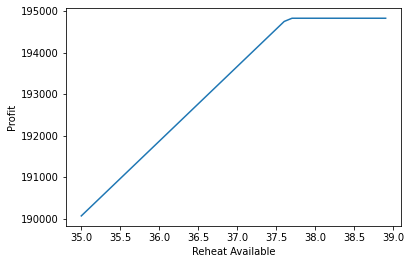

In [ ]:
import matplotlib.pyplot as plt

plt.plot(x_vals,y_vals);
plt.xlabel('Reheat Available');
plt.ylabel('Profit');

**Questions for (d):**
* At approximately what reheat availability does profit stop increasing?
* Notice that the left-most part of the line is linear. Using your outputs from part (c), calculate the slope of that line.
* Based on the plotting code above, create a new plot below for profit vs reheat availabilities between 25 and 40. Describe this plot: How many regions of different linear behaviors do you observe? How would you interpret these? (Let's say we only count regions that are at least 1 reheat-unit wide.)
* Using the same method as above, calculate the slope in each of these linear regions.

**Enter your answers for part (d), first two bullets, below:**

In [ ]:
## WRITE YOUR PART (d), THIRD BULLET, CODE BELOW ##

**Enter your answers for part (d), 3rd and 4th bullet, below:**

**(e)**

* Modify Reference Model 2 so that it prints the sensitivities (by directly modifying the Reference Model 1 code-block after the line `## ADD PART (e) CODE BELOW: ##`). Rerun the notebook.
* In each of the linear-regions identified in part (d), choose a reheat availability and run `steel2` (with the problem otherwise unchanged). Observe the sensitivities.
* Do any of the constraint sensitivities correspond to the slopes you calculated in part (d)? Why might you expect this?

In [ ]:
# WRITE YOUR CODE FOR 2nd BULLET of (e) BELOW:

**Enter your answers for part (d) below:**

**(f)**

The problem is **infeasible** when the reheat availability is 11 or below. Thus, the code block below will throw an error.  Try solving this instance again, but using the strategy we described in the lectures for detecting infeasibility.

In particular, do the following:
* Comment out the `steel2(prod_infoS, rate, availS)` line.
* Create a new function `steel3(...)` by first copy-and-pasting `steel2` as a template. And make the following changes:
  1. Use the default solver rather than GUROBI (remove `solver=...`).
  2. Print only the optimal value (remove the lines that print variable values and sensitivities).
  3.  Run `steel3(prod_infoS, rate, availS)`.

In [ ]:
availS = {'reheat': 11,
          'roll'  : 40}
steel2(prod_infoS, rate, availS) # Will throw an error unless one edits the code

SolverError: ignored

In [ ]:
def steel3(prod_infoS, rate, availS):

  ## ADD PART (f) CODE BELOW ##

In [ ]:
# When you finish part (f), run the following line
steel3(prod_infoS, rate, availS)